# Exploratory Data Analysis


In [6]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define metric code mapping for better readability
METRIC_CODE_MAPPING = {
    "MPF-RPSF": "Rent per Square Foot",
    "MPF-ANN-RENT-CHG": "Annual Rent Change",
    "MPF-HIST-ASK-RENT": "Asking Rent",
    "MPF-HIST-AVG-ASK-RPSF": "Avg Asking Rent per Square Foot",
    "MPF-HIST-CONC-RATIO": "Concessions Ratio",
    "MPF-OCC": "Occupancy Rate",
    "MPF-RENT": "Effective Rent"
}


sns.set(style="whitegrid")  # Set a simple style for plots

## Loading the data

- Load the RealPage-style JSON data from a file, then extract properties from all CBSA entries.
- Flattens the nested metricData into top-level columns.
- Returns a pandas DataFrame

In [8]:
json_path = "./data/cbsa_data.json"

# Read the JSON file
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract property data from each CBSA entry
all_properties = []
for cbsa_entry in data:
    cbsa_code = cbsa_entry["cbsa_code"]
    properties = cbsa_entry.get("data", [])  # Extract 'data' list
    for prop in properties:
        prop["cbsa_code"] = cbsa_code  # Add CBSA code to each property
        all_properties.append(prop)

# Convert extracted property data to a DataFrame
df = pd.DataFrame(all_properties)

# Flatten 'metricData' into separate columns using metricCode as column name
flattened_metrics = []
for row in all_properties:
    metric_map = {}
    for metric in row.get("metricData", []):
        code = metric.get("metricCode")
        value = metric.get("metricValue")
        new_code = METRIC_CODE_MAPPING.get(code, code)  # Rename if in mapping
        metric_map[new_code] = value
    
    flattened_metrics.append(metric_map)

metrics_df = pd.DataFrame(flattened_metrics)

# Concatenate the main DataFrame and the metrics DataFrame
df = pd.concat([df.drop(columns=["metricData"]), metrics_df], axis=1)



## Conduct an exploratory data analysis on the DataFrame, including:
- Overview of missing values
- Basic descriptive statistics
- Distribution plots for key numerical columns
- Scatter plots for correlated metrics (e.g., occupancy vs. rent)

Basic DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   propertyId                       42000 non-null  int64  
 1   propertyName                     42000 non-null  object 
 2   zipCode                          42000 non-null  object 
 3   address                          42000 non-null  object 
 4   city                             42000 non-null  object 
 5   state                            42000 non-null  object 
 6   averageSquareFootage             42000 non-null  int64  
 7   stories                          42000 non-null  object 
 8   stable                           25308 non-null  object 
 9   class                            37847 non-null  object 
 10  latitude                         42000 non-null  object 
 11  longitude                        42000 non-null  object 
 

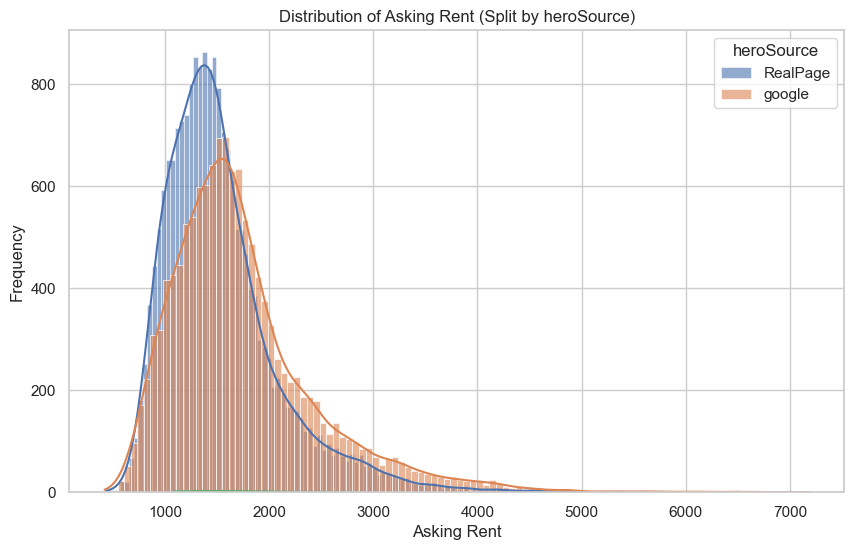

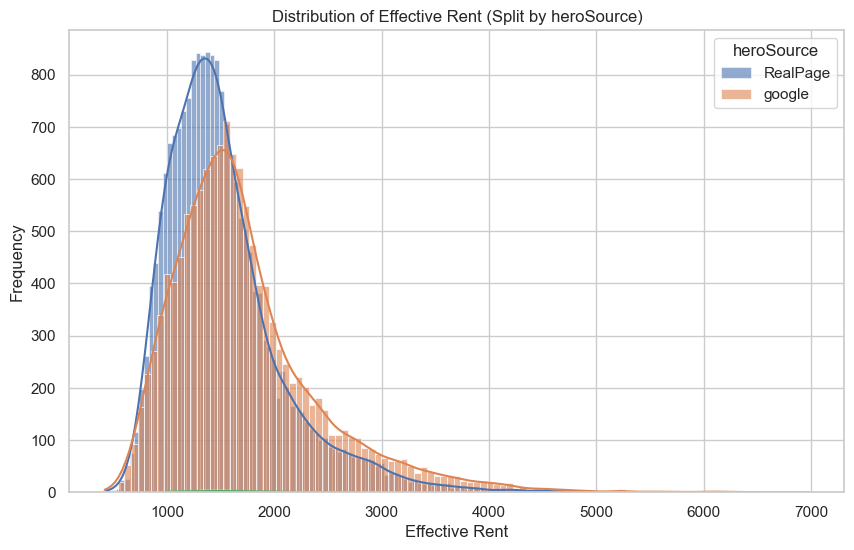

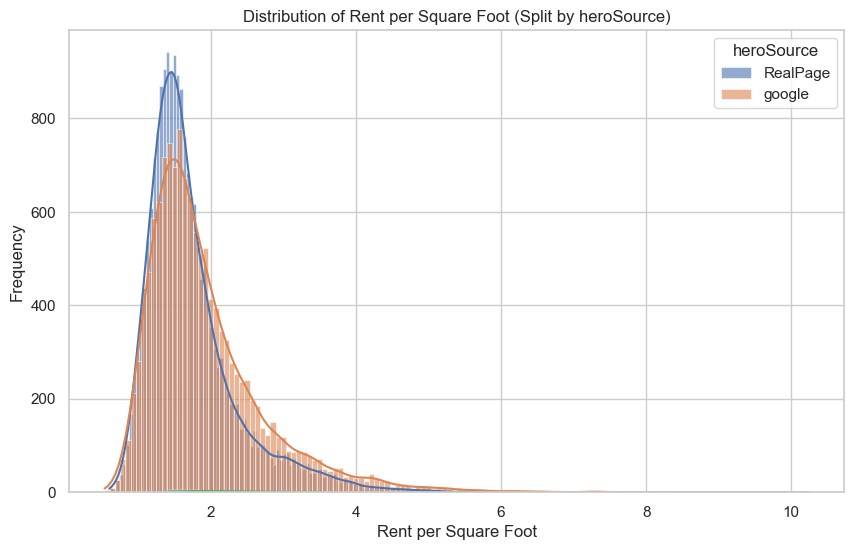

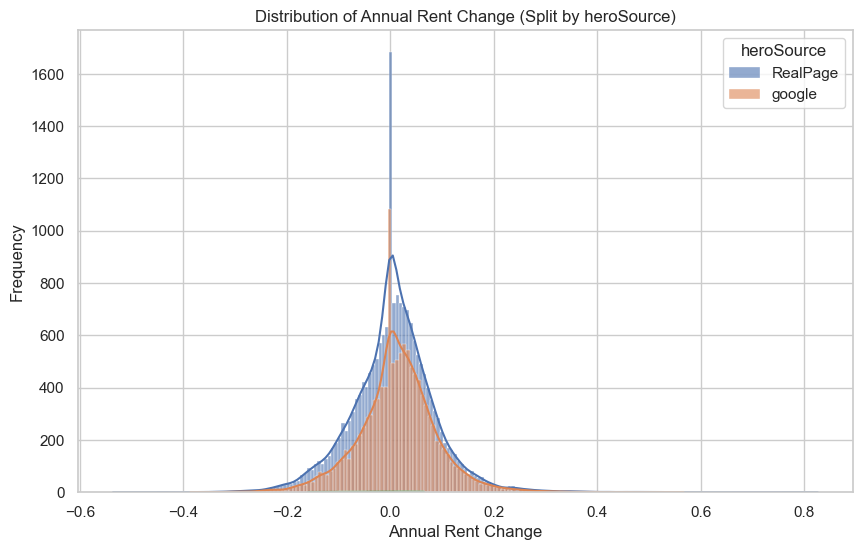

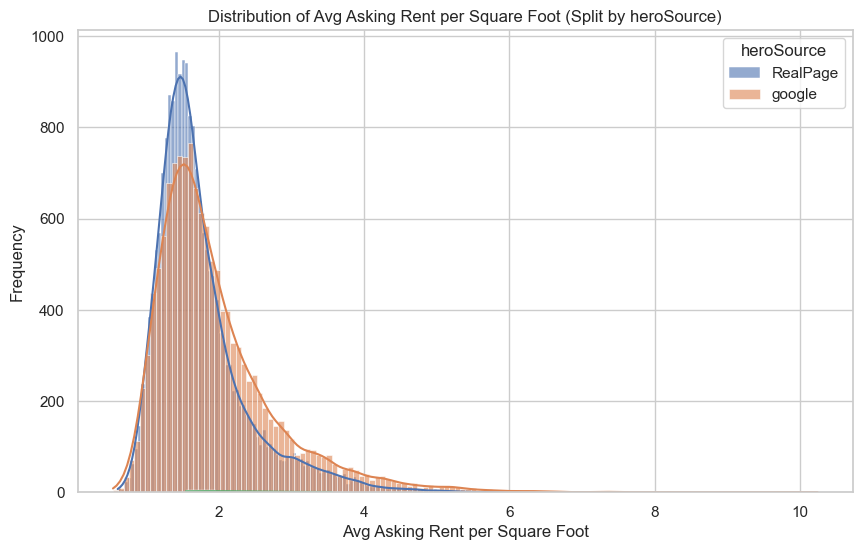

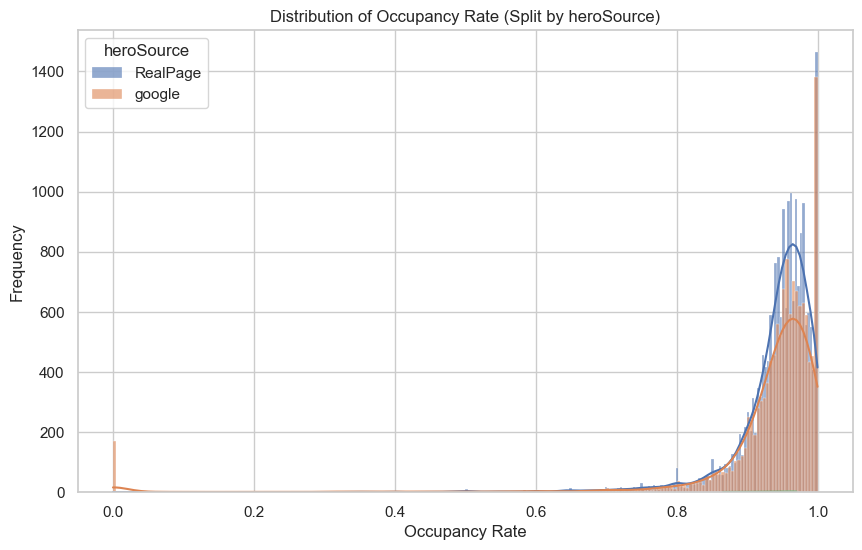

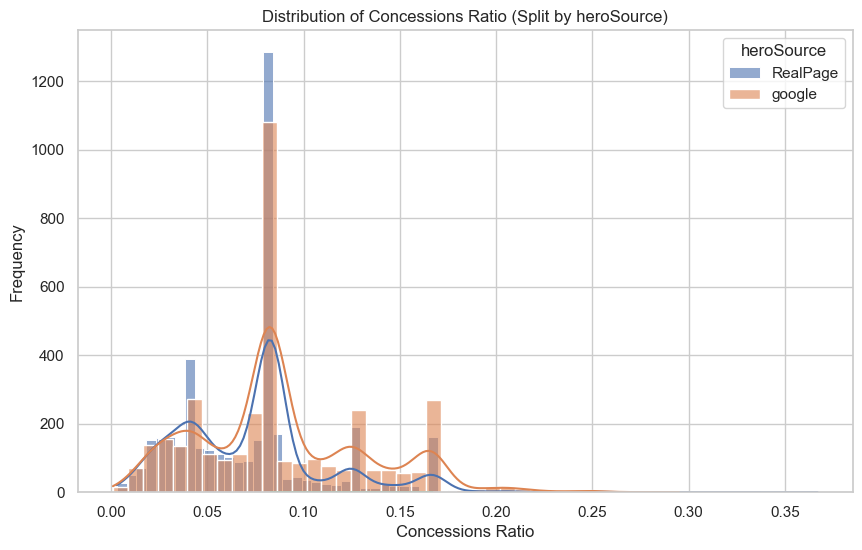

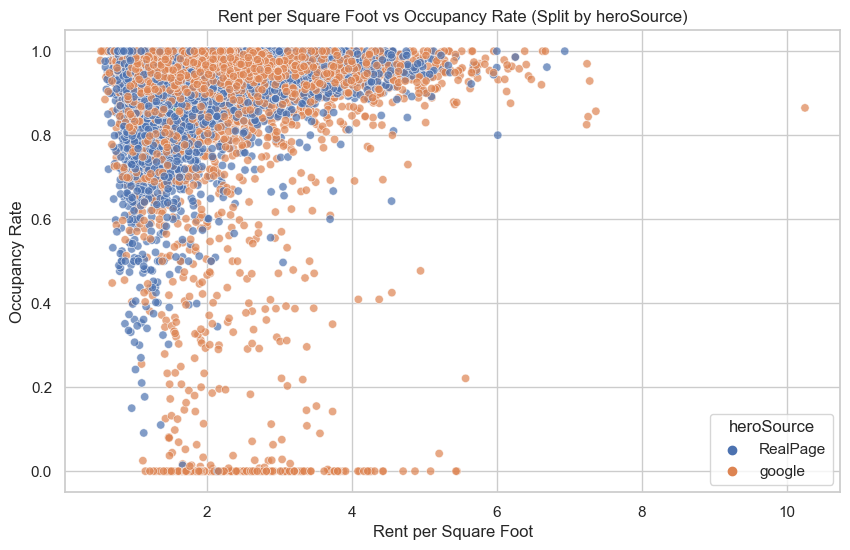

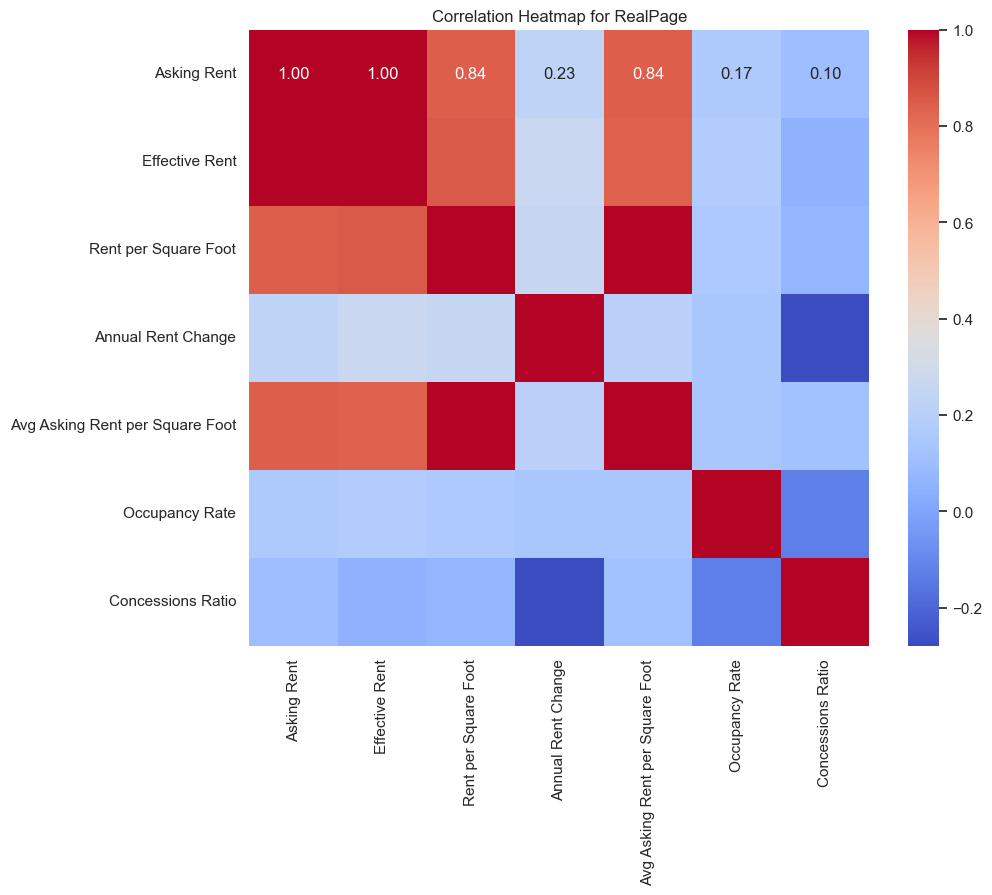

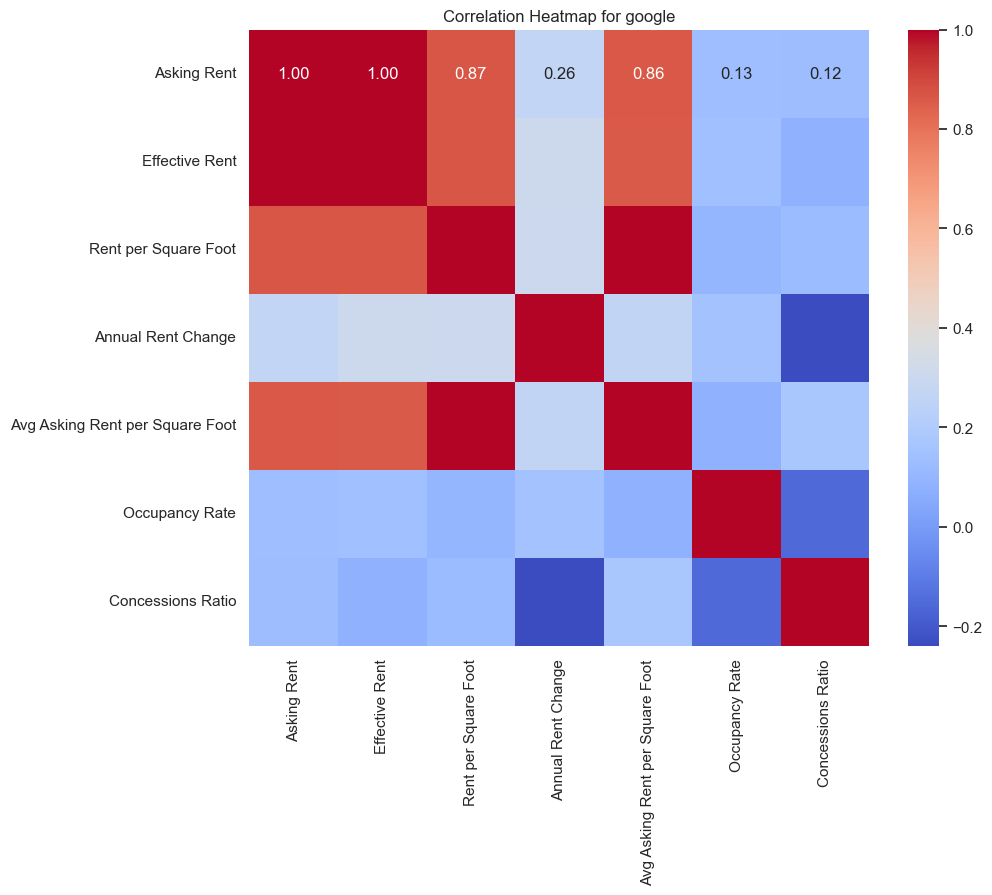

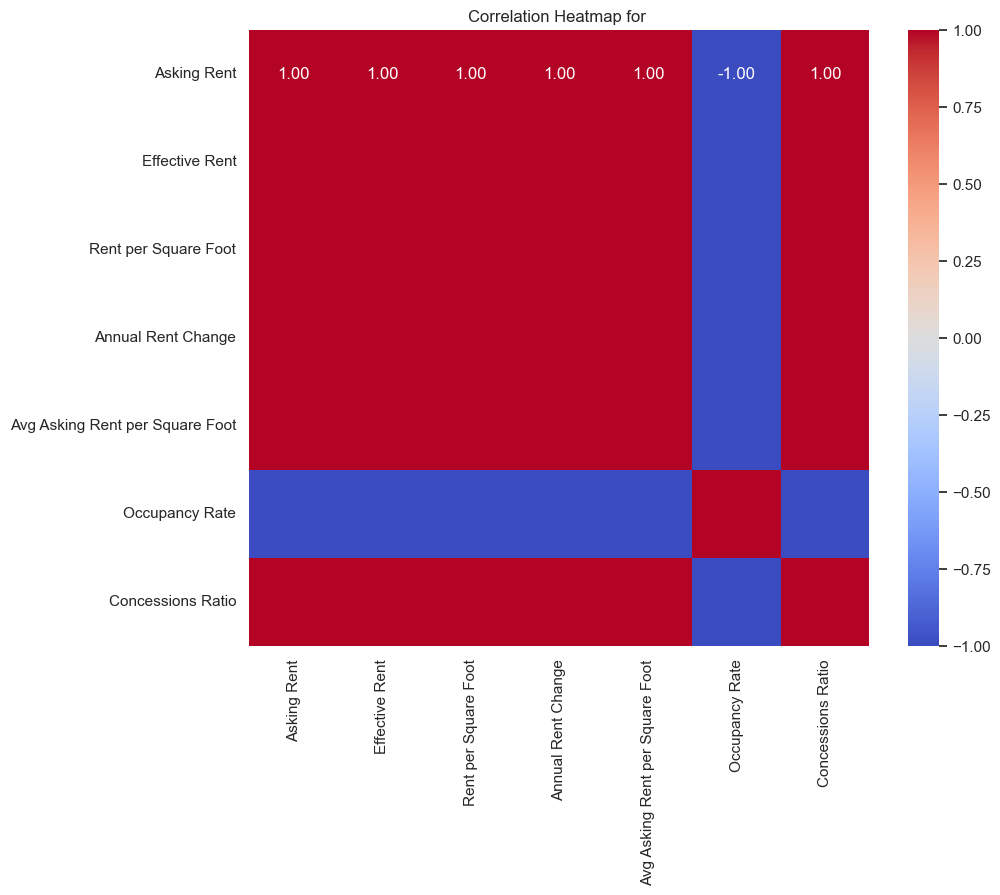

In [11]:
# Display basic DataFrame info
print("Basic DataFrame Info:")
df.info()
print()

# Check for missing values
missing_values = df.isna().sum()
print("Missing Values:")
print(missing_values)
print()

# Display descriptive statistics for numeric columns
print("Descriptive Statistics:")
print(df.describe())
print()

# Select key metrics for visualization
metrics_of_interest = [
    "Asking Rent",
    "Effective Rent",
    "Rent per Square Foot",
    "Annual Rent Change",
    "Avg Asking Rent per Square Foot",
    "Occupancy Rate",
    "Concessions Ratio"
]

# Filter numeric columns
numeric_metrics = [col for col in metrics_of_interest if col in df.columns]

# Get unique heroSource values
hero_sources = df["heroSource"].dropna().unique()

# Plot distributions for selected metrics, split by heroSource
for col in numeric_metrics:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(10, 6))
        for source in hero_sources:
            subset = df[df["heroSource"] == source]
            sns.histplot(subset[col].dropna(), kde=True, label=source, alpha=0.6)

        plt.title(f"Distribution of {col} (Split by heroSource)")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend(title="heroSource")
        plt.show()

# Scatter plot: Occupancy Rate vs Rent per Square Foot, split by heroSource
if "Occupancy Rate" in df.columns and "Rent per Square Foot" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="Rent per Square Foot", y="Occupancy Rate", hue="heroSource", alpha=0.7)
    plt.title("Rent per Square Foot vs Occupancy Rate (Split by heroSource)")
    plt.xlabel("Rent per Square Foot")
    plt.ylabel("Occupancy Rate")
    plt.legend(title="heroSource")
    plt.show()

# Create a correlation heatmap for each heroSource
for source in hero_sources:
    subset = df[df["heroSource"] == source][numeric_metrics].dropna()
    if not subset.empty:
        plt.figure(figsize=(10, 8))
        correlation_matrix = subset.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Correlation Heatmap for {source}")
        plt.show()